In [1]:
# 00_determinism_setup — RUN FIRST in a fresh kernel
import os, sys, random
import numpy as np

SEED = 42

# --- Env vars BEFORE importing TF / XGBoost ---
os.environ["TF_DETERMINISTIC_OPS"]   = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
os.environ["TF_ENABLE_ONEDNN_OPTS"]  = "0"   # shmang nondeterminism në CPU
os.environ["OMP_NUM_THREADS"]        = "1"   # XGBoost (OpenMP) → 1 fije për determinism
os.environ["TF_NUM_INTRAOP_THREADS"] = "1"
os.environ["TF_NUM_INTEROP_THREADS"] = "1"

# (opsionale) fik GPU për TF nëse do vetëm CPU:
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# Seeds
random.seed(SEED)
np.random.seed(SEED)

# Import pas env vars
import tensorflow as tf

try:
    tf.keras.utils.set_random_seed(SEED)
except Exception:
    tf.random.set_seed(SEED)

try:
    tf.config.experimental.enable_op_determinism()
except Exception:
    pass

try:
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
except Exception:
    pass

print("Determinism ready | TF", tf.__version__)


Determinism ready | TF 2.16.1


Epoch 1/40


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1318 - val_loss: 0.0354
Epoch 2/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0430 - val_loss: 0.0253
Epoch 3/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0319 - val_loss: 0.0214
Epoch 4/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0265 - val_loss: 0.0195
Epoch 5/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0231 - val_loss: 0.0182
Epoch 6/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0203 - val_loss: 0.0153
Epoch 7/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0176 - val_loss: 0.0132
Epoch 8/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0158 - val_loss: 0.0123
Epoch 9/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0143 - val_loss: 0.0116
Epoch 10/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0133 - val_loss: 0.0110
Epoch 11/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0124 - val_loss: 0.0105
Epoch 12/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/ste

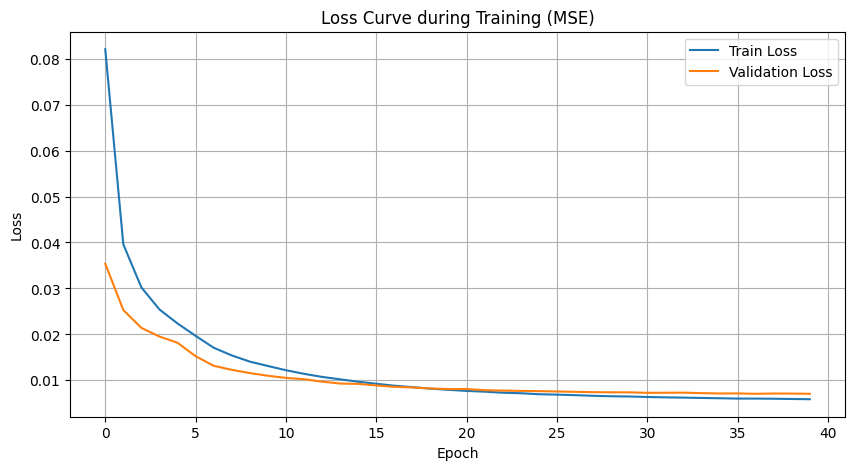


--- Metrics on TEST ---
[GRU only] MAE: 77.20 | RMSE: 99.72 | MAPE: 15.46% | R²: 0.7664 | Accuracy: 84.54%
[**Hybrid (GRU + XGB residual)**] MAE: 53.96 | RMSE: 68.79 | MAPE: 10.63% | R²: 0.8888 | Accuracy: 89.37%


C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Alketa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


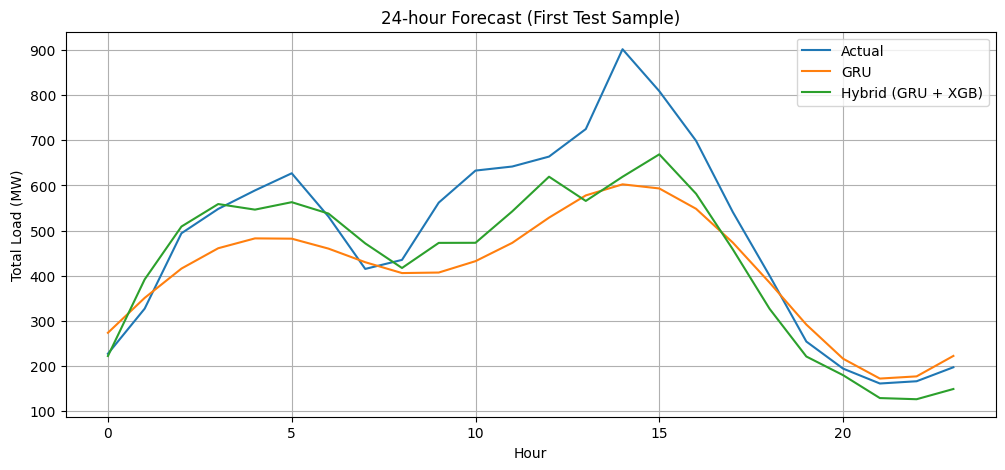

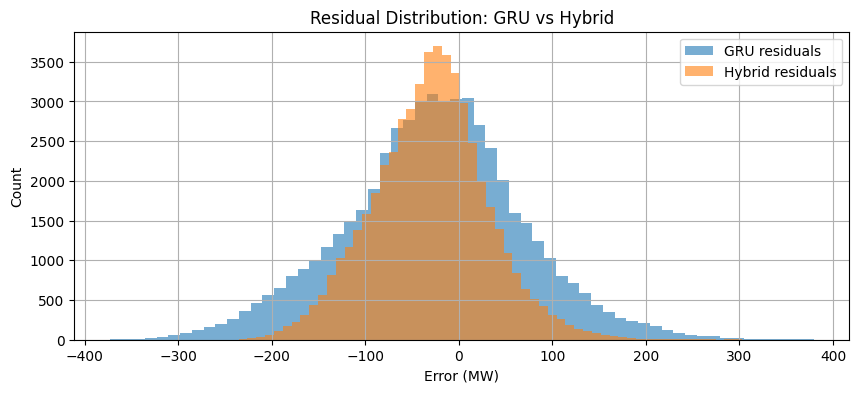

In [2]:
# ======================= Setup =======================versioni i sakte
import re, sys, subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

np.random.seed(42)
tf.random.set_seed(42)

# =================== 1) Load & clean =================
df = pd.read_csv("ost_data_clean.csv", sep=';', engine='python')

df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df['Ora'] = (
    df['Ora']
    .astype(str)
    .str.extract(r'(\d+)', expand=False)  # vetëm një kolonë si Series
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

df['Datetime'] = pd.to_datetime(df['Data'].dt.strftime('%Y-%m-%d') + ' ' + df['Ora'],
                                format='%Y-%m-%d %H', errors='coerce')
df.set_index('Datetime', inplace=True)
df.dropna(inplace=True)

# Total cross-border exchange if missing
if 'Shkembimi fizik nderkufitar' not in df.columns:
    for c in ['Shkembimi fizik nderkufitar AL-ME',
              'Shkembimi fizik nderkufitar AL-KS',
              'Shkembimi fizik nderkufitar AL-GR']:
        if c not in df.columns:
            df[c] = 0.0
    df['Shkembimi fizik nderkufitar'] = (
        df['Shkembimi fizik nderkufitar AL-ME'] +
        df['Shkembimi fizik nderkufitar AL-KS'] +
        df['Shkembimi fizik nderkufitar AL-GR']
    )

# Select base columns (rename here if your CSV uses slightly different names)
base_cols = [
    'Ngarkesa Totale',
    'Prodhimi Total',
    'Shkembimi fizik nderkufitar',
    'Shkembimi fizik nderkufitar AL-ME',
    'Shkembimi fizik nderkufitar AL-KS',
    'Shkembimi fizik nderkufitar AL-GR'
]
df = df[base_cols].copy()

# =============== 2) Time features & lags =============
df['Hour']      = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month']     = df.index.month
df['Weekend']   = (df.index.dayofweek >= 5).astype(int)

# Target lags (known at forecast time)
df['lag_1']   = df['Ngarkesa Totale'].shift(1)
df['lag_24']  = df['Ngarkesa Totale'].shift(24)
df['lag_48']  = df['Ngarkesa Totale'].shift(48)
df['lag_168'] = df['Ngarkesa Totale'].shift(168)

# Rolling stats (help for volatility/peaks)
df['roll_mean_24'] = df['Ngarkesa Totale'].rolling(24).mean()
df['roll_std_24']  = df['Ngarkesa Totale'].rolling(24).std()
df['roll_max_24']  = df['Ngarkesa Totale'].rolling(24).max()
df['roll_min_24']  = df['Ngarkesa Totale'].rolling(24).min()

# Exchange dynamics
df['Total_Exchange'] = (
    df['Shkembimi fizik nderkufitar'] +
    df['Shkembimi fizik nderkufitar AL-ME'] +
    df['Shkembimi fizik nderkufitar AL-KS'] +
    df['Shkembimi fizik nderkufitar AL-GR']
)
df['Delta_Exchange'] = df['Total_Exchange'].diff()

# Fourier seasonality
def add_fourier(df_in, tag, period, K=3):
    t = np.arange(len(df_in), dtype=float)
    for k in range(1, K+1):
        df_in[f'{tag}_sin_{period}_{k}'] = np.sin(2*np.pi*k*t/period)
        df_in[f'{tag}_cos_{period}_{k}'] = np.cos(2*np.pi*k*t/period)
    return df_in

df = add_fourier(df, 'fourier_daily', 24,  K=3)
df = add_fourier(df, 'fourier_weekly', 168, K=3)

df.dropna(inplace=True)

# Target/feature names
target_col = 'Ngarkesa Totale'
all_feat_cols = [c for c in df.columns if c != target_col]

# ============ 3) Make 24→24 sequences ================
n_input  = 24
n_output = 24
t_idx = df.columns.get_loc(target_col)

def make_sequences(df_frame, n_in=24, n_out=24):
    """Return X (N, n_in, F), y (N, n_out), hours (N, n_out), times (N, n_out)"""
    X, y, hours, times = [], [], [], []
    idx = df_frame.index
    for i in range(n_in, len(df_frame) - n_out + 1):
        X.append(df_frame.iloc[i-n_in:i].values)
        y.append(df_frame.iloc[i:i+n_out, t_idx].values)
        hours.append(idx[i:i+n_out].hour.values)
        times.append(idx[i:i+n_out].values)  # timestamps for each horizon
    return np.array(X), np.array(y), np.array(hours), np.array(times)

# Time split (70/10/20)
n_total    = len(df)
i_train_end = int(n_total * 0.70)
i_val_end   = int(n_total * 0.80)

df_train = df.iloc[:i_train_end].copy()
df_val   = df.iloc[i_train_end:i_val_end].copy()
df_test  = df.iloc[i_val_end:].copy()

# ============== 4) Scale only on TRAIN ================
scaler = MinMaxScaler()
scaler.fit(df_train)

df_train_s = pd.DataFrame(scaler.transform(df_train), columns=df.columns, index=df_train.index)
df_val_s   = pd.DataFrame(scaler.transform(df_val),   columns=df.columns, index=df_val.index)
df_test_s  = pd.DataFrame(scaler.transform(df_test),  columns=df.columns, index=df_test.index)

X_train, y_train, hours_train, times_train = make_sequences(df_train_s, n_input, n_output)
X_val,   y_val,   hours_val,   times_val   = make_sequences(df_val_s,   n_input, n_output)
X_test,  y_test,  hours_test,  times_test  = make_sequences(df_test_s,  n_input, n_output)

input_shape = (X_train.shape[1], X_train.shape[2])

# Helper to inverse ONLY target
t_min = scaler.data_min_[t_idx]
t_max = scaler.data_max_[t_idx]
def inv_target(y_scaled):
    return y_scaled * (t_max - t_min) + t_min

# ================= 5) Baseline GRU ====================
def build_gru():
    model = Sequential([
        GRU(128, return_sequences=False,
            kernel_regularizer=l2(1e-4), recurrent_regularizer=l2(1e-4), bias_regularizer=l2(1e-4),
            input_shape=input_shape),
        Dropout(0.3),
        Dense(24, kernel_regularizer=l2(1e-4))
    ])
    model.compile(optimizer=Adam(learning_rate=5e-4), loss='mse')
    return model

gru = build_gru()
early = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

# <<<— SAVE HISTORY SO WE CAN PLOT TRAIN vs VAL LOSS —>>>
history = gru.fit(
    X_train, y_train,
    epochs=40, batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early],
    verbose=1
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve during Training (MSE)')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.grid(True); plt.legend()
plt.savefig("loss_curve_GRU.png", dpi=600, bbox_inches='tight')
plt.show()

# Predictions (scaled)
y_pred_tr_s = gru.predict(X_train, verbose=0)
y_pred_va_s = gru.predict(X_val,   verbose=0)
y_pred_te_s = gru.predict(X_test,  verbose=0)

# Back to MW
y_tr_true = inv_target(y_train); y_tr_pred = inv_target(y_pred_tr_s)
y_va_true = inv_target(y_val);   y_va_pred = inv_target(y_pred_va_s)
y_te_true = inv_target(y_test);  y_te_pred = inv_target(y_pred_te_s)

# ================= 6) Build residual datasets for XGB =================
# Residuals to learn: r = y_true - y_gru
res_tr = y_tr_true - y_tr_pred
res_va = y_va_true - y_va_pred

# Build tabular features for each horizon using ORIGINAL (unscaled) engineered frame.
# We will pick features at the TARGET TIMESTAMP of each horizon.
engineered_df = df  # unscaled features & target

# Columns for XGB (exclude target itself)
xgb_feat_cols = [c for c in engineered_df.columns if c != target_col]

def rows_to_features(times_2d):
    """For each sample & horizon time, fetch feature row from engineered_df."""
    N, H = times_2d.shape
    Feat = []
    for i in range(N):
        rows = engineered_df.loc[times_2d[i]].reindex(columns=xgb_feat_cols).values  # (H, F)
        Feat.append(rows)
    return np.array(Feat)  # (N, H, F)

X_tab_tr = rows_to_features(times_train)   # (Ntr,24,F)
X_tab_va = rows_to_features(times_val)     # (Nva,24,F)
X_tab_te = rows_to_features(times_test)    # (Nte,24,F)

# Flatten per horizon for training 24 separate models
Ntr, H, F = X_tab_tr.shape
Nva = X_tab_va.shape[0]
Nte = X_tab_te.shape[0]

# ================= 7) Emphasize peaks via sample weights =================
# Define peaks by top 10% of true load in (train+val)
all_true_trva = np.concatenate([y_tr_true.reshape(-1), y_va_true.reshape(-1)])
p90_load = np.percentile(all_true_trva, 90)

# Define large-error threshold by top 10% absolute residual on (train+val)
all_res_trva = np.concatenate([np.abs(res_tr.reshape(-1)), np.abs(res_va.reshape(-1))])
p90_res = np.percentile(all_res_trva, 90)

# Weighting scheme
def make_weights(y_true_2d, res_2d):
    Y = y_true_2d.reshape(-1)
    R = np.abs(res_2d.reshape(-1))
    w = np.ones_like(Y, dtype=float)
    w[Y >= p90_load] += 1.0          # more weight to peak loads
    w[R >= p90_res]  += 1.0          # more weight to large residuals
    return w

w_tr = make_weights(y_tr_true, res_tr)   # (Ntr*24,)
w_va = make_weights(y_va_true, res_va)   # not used directly, but could for CV

# ================= 8) Train 24 XGB models (one per horizon) ==============
xgb_models = []
for h in range(H):
    # Stack train rows for horizon h
    Xh_tr = X_tab_tr[:, h, :]            # (Ntr, F)
    yh_tr = res_tr[:, h]                 # (Ntr,)
    wh_tr = w_tr[h::H]                  # pick weights aligned to horizon positions

    model_h = XGBRegressor(
        n_estimators=700,
        learning_rate=0.04,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        min_child_weight=1,
        tree_method="hist",      # CPU histogram → determinist
        grow_policy="depthwise", # (opsionale, e qëndrueshme)
        n_jobs=1,                # 1 fije → shmang paqartësi nga paralelizmi
        random_state=SEED
    )

    model_h.fit(Xh_tr, yh_tr, sample_weight=wh_tr, verbose=False)
    xgb_models.append(model_h)

# ================= 9) Hybrid prediction on TEST ==========================
res_hat_te = np.zeros_like(y_te_pred)  # (Nte,24)
for h in range(H):
    Xh_te = X_tab_te[:, h, :]          # (Nte,F)
    res_hat_te[:, h] = xgb_models[h].predict(Xh_te)

y_te_hybrid = y_te_pred + res_hat_te   # corrected forecast in MW

# ================= 10) Metrics & comparison =============================
def eval_metrics(y_true_2d, y_pred_2d, tag):
    yt = y_true_2d.reshape(-1); yp = y_pred_2d.reshape(-1)
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    eps  = 1e-6
    yt_safe = np.where(yt == 0, eps, yt)
    mape = mean_absolute_percentage_error(yt_safe, yp) * 100
    r2   = r2_score(yt, yp)
    acc  = 100 - mape
    print(f"[{tag}] MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.4f} | Accuracy: {acc:.2f}%")
    return mae, rmse, mape, r2, acc

print("\n--- Metrics on TEST ---")
eval_metrics(y_te_true, y_te_pred,   "GRU only")
eval_metrics(y_te_true, y_te_hybrid, "**Hybrid (GRU + XGB residual)**")

# ================= 11) Visual check (first test window) ==================
plt.figure(figsize=(12,5))
plt.plot(y_te_true[0],   label='Actual')
plt.plot(y_te_pred[0],   label='GRU')
plt.plot(y_te_hybrid[0], label='Hybrid (GRU + XGB)')
plt.title('24-hour Forecast (First Test Sample)')
plt.xlabel('Hour'); plt.ylabel('Total Load (MW)')
plt.grid(True); plt.legend()
plt.savefig("forecast_comparison_hybrid.png", dpi=600, bbox_inches='tight') 
plt.show()

# Optional: distribution of residuals reduction
plt.figure(figsize=(10,4))
plt.hist((y_te_true - y_te_pred).reshape(-1),   bins=60, alpha=0.6, label='GRU residuals')
plt.hist((y_te_true - y_te_hybrid).reshape(-1), bins=60, alpha=0.6, label='Hybrid residuals')
plt.title('Residual Distribution: GRU vs Hybrid')
plt.xlabel('Error (MW)'); plt.ylabel('Count')
plt.legend(); plt.grid(True)
plt.savefig("residuals_distribution_hybrid.png", dpi=600, bbox_inches='tight')  
plt.show()


In [1]:
import subprocess, sys
with open("requirements_lock.txt","w") as f:
    f.write(subprocess.check_output([sys.executable,"-m","pip","freeze"]).decode())